# Parallelization and scaling

## Agenda

### 1- Multi-QPU: parallel sampling and observe
### 2- Hamiltonian Batching
### 3- Multi-GPU and scaling
### 4- Remote multi-QPU

#### 1- Multi-QPU: parallel sampling and observe

In the multi-QPU mode (```mqpu``` option), the NVIDIA target provides a simulated QPU for every available NVIDIA GPU on the underlying system. Each QPU simulated via a ```cuStateVec``` simulator backend as defined by the NVIDIA target. This is useful for distributing separate quantum circuits.

<div>
<img src="./circuit-mqpu.png" width="500">
</div>

- ### Example with `sample` algorithmic primitives

#### Hadamard test:

<div>
<img src="./hadamard-test.png" width="600">
</div>


Consider the observable $O$ and two generic quantum states $\ket{\psi}$ and $\ket{\phi}$. We want to calculate the quantity
$$
\bra{\psi} O \ket{\phi}.
$$
where $O$ is a Pauli operator.

First of all we shall prepare the states $\ket{\psi}$ and $\ket{\phi}$ using a quantum circuit for each of them. So we  have
$$
\ket{\psi} = U_{\psi}\ket{0} \qquad \ket{\phi} = U_{\phi}\ket{0}
$$

Let's define an observable we want to use:
$$
O = X_1X_2
$$

Now we can evaluate the matrix element using the following fact:
$$
\bra{\psi}O\ket{\phi} = \bra{0}U_\psi^\dagger O U_\phi\ket{0}
$$
This is just an expectation value which can be solved with a simple Hadamard test. The probability to measure $0$ or $1$ in the ancilla qubit is

$$
P(0) = \frac{1}{2} \left[ I + Re \bra{\psi} O \ket{\phi} \right]
$$

$$
P(1) = \frac{1}{2} \left[ I - Re \bra{\psi} O \ket{\phi} \right]
$$

The difference between the probability of $0$ and $1$ gives 

$$
P(0)-P(1) = Re \bra{\psi} O \ket{\phi}
$$

In [3]:
import cudaq
import numpy as np

cudaq.set_target("nvidia", option='mqpu')

target = cudaq.get_target()
qpu_count = target.num_qpus()
print("Number of QPUs:", qpu_count)

@cudaq.kernel
def U_psi(q:cudaq.qview, theta:float):
    ry(theta, q[1])

@cudaq.kernel
def U_phi(q:cudaq.qview, theta: float):
    rx(theta, q[0])

@cudaq.kernel  
def apply_pauli(q:cudaq.qview):
    x(q[0])
    x(q[1])

@cudaq.kernel
def kernel(n:int, angle:float, theta:float):
    
    ancilla = cudaq.qubit()
    q = cudaq.qvector(n)
    
    h(ancilla)
    
    cudaq.control(U_phi, ancilla, q, theta)
    cudaq.control(apply_pauli, ancilla, q)
    cudaq.control(U_psi, ancilla, q, angle)
    
    h(ancilla)
    
    mz(ancilla)

Number of QPUs: 5


In [4]:
shots = 100000  
#angle = [0.0, 1.5,3.14,0.7]
#theta = [0.6, 1.2 ,2.2 ,3.0]

dim=4
np.random.seed(42)
angle = np.random.normal(0, 1, dim).tolist()
theta= np.random.normal(0, 1, dim).tolist()

qubit_num = 2

result = []
for i in range(4):  
    count = cudaq.sample_async(kernel, qubit_num, angle[i], theta[i], shots_count = shots, qpu_id = i)  
    result.append(count)  

mean_val = np.zeros(len(angle))
i = 0
for count in result:
    print(i)
    i_result = count.get()
    print(i_result)
    mean_val[i] = (i_result['0'] - i_result['1']) / shots
    error = np.sqrt(2 * i_result['0'] * i_result['1'] / shots) / shots
    print('Observable QC: ',  mean_val[i],'+ -', error)
    i += 1

0
{ 0:49674 1:50326 }

Observable QC:  -0.00652 + - 0.002236020448922594
1
{ 0:49704 1:50296 }

Observable QC:  -0.00592 + - 0.002236028794090094
2
{ 0:49952 1:50048 }

Observable QC:  -0.00096 + - 0.002236066947119428
3
{ 0:49942 1:50058 }

Observable QC:  -0.00116 + - 0.0022360664730727486


- #### Applications: Hadamrd test has been recently employed to predict drug toxicity; see this [paper](https://arxiv.org/pdf/2403.18997) to learn more

<div>
<img src="./drug-toxicity.png" width="600">
</div>

- ### Example with `observe` algorithmic primitives:

#### Quantum neural network example:

<div>
<img src="./qnn-circ.png" width="400">
</div>

In [26]:
import cudaq
from cudaq import spin
import numpy as np

import timeit

np.random.seed(1)

cudaq.set_target("nvidia", option="mqpu")
target = cudaq.get_target()
qpu_count = target.num_qpus()
print("Number of QPUs:", qpu_count)

qubit_count = 10
sample_count = 10000

ham = spin.z(0)

parameter_count = 3*qubit_count

# Below we run a circuit for 10000 different input parameters.
parameters = np.random.default_rng(13).uniform(low=0,high=1,size=(sample_count,parameter_count))

print('Parameter shape: ', parameters.shape)

@cudaq.kernel
def qnn(theta:list[float]):
    qubits = cudaq.qvector(qubit_count)

    count=0
    for i in range(qubit_count):
        u3(theta[count], theta[count+1], theta[count+2], qubits[i])
        count+=3
    
    for i in range(qubit_count-1):
        x.ctrl(qubits[i], qubits[i+1])
    
    x.ctrl(qubits[qubit_count-1], qubits[0])
    
          
# Single-GPU: broadcasting:

start_time = timeit.default_timer()

result = cudaq.observe(qnn, ham, parameters)
energies = np.array([r.expectation() for r in result])

end_time = timeit.default_timer()
print('Elapsed time (s) for single GPU: ', end_time-start_time)

#print('Energies from single GPU')
#print(energies)


# Multi-GPU

# We split our parameters into 4 arrays since we have 4 GPUs available.
xi = np.split(parameters,4)

print('We have', parameters.shape[0],
      'parameters which we would like to execute')

print('We split this into', len(xi), 'batches of', xi[0].shape[0], ',',
      xi[1].shape[0], ',', xi[2].shape[0], ',', xi[3].shape[0])

print('Shape after splitting', xi[0].shape)
asyncresults = []

start_time = timeit.default_timer()
for i in range(len(xi)):
    for j in range(xi[i].shape[0]):
        qpu_id = i * 4 // len(xi)
        asyncresults.append(
            cudaq.observe_async(qnn, ham, xi[i][j, :], qpu_id=qpu_id))

#print('Energies from multi-GPUs')
for result in asyncresults:
    observe_result = result.get()
    got_expectation = observe_result.expectation()
    #print(got_expectation)
end_time = timeit.default_timer()
print(f'Elapsed time (s) for multi-QPU with {qpu_count} QPUs is {end_time-start_time}')


Number of QPUs: 5
Parameter shape:  (10000, 30)
Elapsed time (s) for single GPU:  7.051674715010449
We have 10000 parameters which we would like to execute
We split this into 4 batches of 2500 , 2500 , 2500 , 2500
Shape after splitting (2500, 30)
Elapsed time (s) for multi-QPU with 5 QPUs is 1.812091946019791


#### Extend to multi-node multi-GPUs:

``` python


import cudaq
from cudaq import spin
import numpy as np
import timeit

cudaq.mpi.initialize()

np.random.seed(1)

cudaq.set_target("nvidia", option="mqpu")
target = cudaq.get_target()
my_qpu_count = target.num_qpus()
qpu_count = my_qpu_count * cudaq.mpi.num_ranks()
print(f"My rank {cudaq.mpi.rank()} of {cudaq.mpi.num_ranks()}")
print("Number of my QPUs:", my_qpu_count)
print("Number of QPUs total:", qpu_count)

qubit_count = 24
sample_count = 10000

ham = spin.z(0)


# Below we run a circuit for 1200 different sets of input parameters.
parameters = np.random.default_rng(13).uniform(low=0,high=1,size=(sample_count, qubit_count))

print('Parameter shape: ', parameters.shape)

@cudaq.kernel
def kernel_rx(theta:list[float]):
    qubits = cudaq.qvector(qubit_count)

    for i in range(qubit_count):
        rx(theta[i], qubits)

# split per node
split_params = np.split(parameters, cudaq.mpi.num_ranks())
my_rank_params = split_params[cudaq.mpi.rank()]

# Multi-GPU
# We split our parameters into per-GPU arrays
xi = np.split(my_rank_params, my_qpu_count)

print('We have', parameters.shape[0],
      'parameter sets which we would like to execute')

print('We have', my_rank_params.shape[0],
      'parameter sets on this rank')

print('Number of param sets on this rank:', len(xi))
print('Shape of each parameter set after splitting:', xi[0].shape)
asyncresults = []

start_time = timeit.default_timer()


# For each batch
for i in range(len(xi)):
    # For each parameter set
    for j in range(xi[i].shape[0]):
        asyncresults.append(
            cudaq.observe_async(kernel_rx, ham, xi[i][j], qpu_id=i))



exp_list = []
for result in asyncresults:
    observe_result = result.get() # sync happens here.
    got_expectation = observe_result.expectation()
    exp_list.append(got_expectation)

end_time = timeit.default_timer()

print(f'Elapsed time (s) for multi-QPU with {my_qpu_count} QPUs is {end_time-start_time}')
print(f"My rank has {len(exp_list)} results")
total_results = cudaq.mpi.all_gather(len(exp_list)*cudaq.mpi.num_ranks(), exp_list)
print(f"My rank has {len(total_results)} results after all gather")


cudaq.mpi.finalize()

```

#### Multi-reference quantum krylov subspace: H2 example

Instead of preparing a wavefunction directly on the QC device and measure the energy, we use the  QC device to prepare a simpler pairwise superposition of the state.


<div>
<img src="./mrqks.png" width="600">
</div>

<div>
<img src="./WF-MRQKS.png" width="400">
</div>

<div>
<img src="./ovlp-ham-MRQKS.png" width="500">
<div>

<div>
<img src="./eigval-MRQKS.png" width="300">
<div>

To learn more, see this [paper](https://arxiv.org/pdf/1911.05163)

In [1]:
import cudaq
import numpy as np
import scipy

cudaq.set_target("nvidia", option='mqpu,fp64')

# Define H2 molecule
geometry = [('H', (0.0, 0, 0)), ('H', (0.0, 0.0, 0.7474))]

hamiltonian, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, 'sto-3g', 1, 0)

electron_count = data.n_electrons
qubits_num = 2 * data.n_orbitals

spin_ham_matrix = hamiltonian.to_matrix()
e, c = np.linalg.eig(spin_ham_matrix)

# Find the ground state energy and the corresponding eigenvector
print('Ground state energy (classical simulation)= ', np.min(e), ', index= ',
      np.argmin(e))
min_indices = np.argmin(e)

# Eigen vector can be used to initialize the qubits
vec = c[:, min_indices]

Ground state energy (classical simulation)=  (-1.1371757102406848+0j) , index=  3


In [2]:
# Collect coefficients from a spin operator so we can pass them to a kernel
def termCoefficients(ham: cudaq.SpinOperator) -> list[complex]:
    result = []
    ham.for_each_term(lambda term: result.append(term.get_coefficient()))
    return result

# Collect Pauli words from a spin operator so we can pass them to a kernel
def termWords(ham: cudaq.SpinOperator) -> list[str]:
    result = []
    ham.for_each_term(lambda term: result.append(term.to_string(False)))
    return result


coefficient = termCoefficients(hamiltonian)
pauli_string = termWords(hamiltonian)

In [3]:
@cudaq.kernel
def U_psi(qubits: cudaq.qview, dt: float, coefficients: list[complex],
          words: list[cudaq.pauli_word]):
    # Compute U_m = exp(-i m dt H)
    for i in range(len(coefficients)):
        exp_pauli(dt * coefficients[i].real, qubits, words[i])


@cudaq.kernel
def U_phi(qubits: cudaq.qview, dt: float, coefficients: list[complex],
          words: list[cudaq.pauli_word]):
    # Compute U_n = exp(-i n dt H)
    for i in range(len(coefficients)):
        exp_pauli(dt * coefficients[i].real, qubits, words[i])


@cudaq.kernel
def apply_pauli(qubits: cudaq.qview, word: list[int]):

    # Add H (Hamiltonian operator)
    for i in range(len(word)):
        if word[i] == 1:
            x(qubits[i])
        if word[i] == 2:
            y(qubits[i])
        if word[i] == 3:
            z(qubits[i])


@cudaq.kernel
def qfd_kernel(dt_alpha: float, dt_beta: float, coefficients: list[complex],
               words: list[cudaq.pauli_word], word_list: list[int],
               vec: list[complex]):

    ancilla = cudaq.qubit()
    qreg = cudaq.qvector(vec)

    h(ancilla)

    x(ancilla)
    cudaq.control(U_psi, ancilla, qreg, dt_alpha, coefficients, words)
    x(ancilla)

    cudaq.control(apply_pauli, ancilla, qreg, word_list)
    cudaq.control(U_phi, ancilla, qreg, dt_beta, coefficients, words)

In [4]:
def pauli_str(pauli_word, qubits_num):

    my_list = []
    for i in range(qubits_num):
        if str(pauli_word[i]) == 'I':
            my_list.append(0)
        if str(pauli_word[i]) == 'X':
            my_list.append(1)
        if str(pauli_word[i]) == 'Y':
            my_list.append(2)
        if str(pauli_word[i]) == 'Z':
            my_list.append(3)
    return my_list

In [5]:
# Define the spin-op x for real component and y for the imaginary component.

x_0 = cudaq.spin.x(0)
y_0 = cudaq.spin.y(0)

In [6]:
#Define parameters for the quantum Krylov space

dt = 0.5

# Dimension of the Krylov space
m_qfd = 4

In [7]:
# Compute the basis overlap matrix

# Add identity operator to compute overlap of basis

observe_op = 1.0
for m in range(qubits_num):
    observe_op *= cudaq.spin.i(m)

identity_word = observe_op.to_string(False)

pauli_list = pauli_str(identity_word, qubits_num)
#print(pauli_list)

wf_overlap = np.zeros((m_qfd, m_qfd), dtype=complex)

collect_overlap_real=[]
collect_overlap_img=[]

count=0
for m in range(m_qfd):
    dt_m = dt * m
    for n in range(m, m_qfd):
        dt_n = dt * n
        
        count_id=count%2
        #print(count_id)
        collect_overlap_real.append(cudaq.observe_async(qfd_kernel, x_0, dt_m, dt_n,
                                coefficient, pauli_string, pauli_list, vec, qpu_id=count_id))
        
        collect_overlap_img.append(cudaq.observe_async(qfd_kernel, y_0, dt_m, dt_n,
                                coefficient, pauli_string, pauli_list, vec, qpu_id=count_id+2))
        count+=1

tot_dim=0

for n in range(m_qfd):
    for m in range(n,m_qfd):
        observe_result = collect_overlap_real[tot_dim].get()
        real_val = observe_result.expectation()  
    
        observe_result=collect_overlap_img[tot_dim].get()
        img_val=observe_result.expectation() 
    
        wf_overlap[m, n] = real_val + img_val * 1j
        if n != m:
            wf_overlap[n, m] = np.conj(wf_overlap[m, n])
        
        tot_dim+=1

#print(wf_overlap)  

In [8]:
# Compute the matrix Hamiltonian


ham_matrx = np.zeros((m_qfd, m_qfd), dtype=complex)


for m in range(m_qfd):
    dt_m = dt * m
    for n in range(m, m_qfd):
        dt_n = dt * n

        ham_matrix_real=[]
        ham_matrix_imag=[]
        
        count=0
        tot_e = np.zeros(2)
        for coef, word in zip(coefficient, pauli_string):
            count_id=count%2
            #print(coef,word)

            pauli_list = pauli_str(word, qubits_num)
            #print(pauli_list)

            ham_matrix_real.append(cudaq.observe_async(qfd_kernel, x_0, dt_m, dt_n,
                                    coefficient, pauli_string, pauli_list, vec, qpu_id=count_id))
            ham_matrix_imag.append(cudaq.observe_async(qfd_kernel, y_0, dt_m, dt_n,
                                    coefficient, pauli_string, pauli_list, vec, qpu_id=count_id+2))

            count+=1
        
        i=0
        for coef in coefficient:
            
            observe_result = ham_matrix_real[i].get()
            real_val = observe_result.expectation()  
    
            observe_result=ham_matrix_imag[i].get()
            img_val=observe_result.expectation() 
            
            tot_e[0] += real_val * coef.real 
            tot_e[1] += img_val * coef.imag
            
            i+=1
        
        ham_matrx[m, n] = tot_e[0] + tot_e[1] * 1j
        if n != m:
            ham_matrx[n, m] = np.conj(ham_matrx[m, n])

#print(ham_matrx)


In [9]:
# Diagonalize the matrix


def eig(H, s):
    #Solver for generalized eigenvalue problem

    # HC = SCE

    THRESHOLD = 1e-20
    s_diag, u = scipy.linalg.eig(s)
    s_prime = []
    for sii in s_diag:
        if np.imag(sii) > 1e-7:
            raise ValueError(
                "S may not be hermitian, large imag. eval component.")
        if np.real(sii) > THRESHOLD:
            s_prime.append(np.real(sii))

    X_prime = np.zeros((len(s_diag), len(s_prime)), dtype=complex)

    for i in range(len(s_diag)):
        for j in range(len(s_prime)):
            X_prime[i][j] = u[i][j] / np.sqrt(s_prime[j])

    H_prime = (((X_prime.conjugate()).transpose()).dot(H)).dot(X_prime)
    e_prime, C_prime = scipy.linalg.eig(H_prime)
    C = X_prime.dot(C_prime)

    return e_prime, C

In [10]:
eigen_value, eigen_vect = eig(ham_matrx[0:m_qfd, 0:m_qfd], wf_overlap[0:m_qfd,0:m_qfd])
print('Energy from QFD:')
print(np.min(eigen_value))

Energy from QFD:
(-1.136753643031334+2.056438073599281e-19j)


#### Parallel with parameter shift gradient:

In [16]:
import openfermion
import openfermionpyscf
from openfermion.transforms import jordan_wigner, get_fermion_operator

import cudaq
from scipy.optimize import minimize
import numpy as np

# GPU
cudaq.set_target("nvidia", option="fp64")

# 1- Classical pre-processing:
geometry=[('O', (0.1173,0.0,0.0)), ('H', (-0.4691,0.7570,0.0)), ('H', (-0.4691,-0.7570,0.0))]
basis='sto3g'
multiplicity=1
charge=0
ncore=3
norb_cas, nele_cas = (3,4)

molecule = openfermionpyscf.run_pyscf(openfermion.MolecularData(geometry, basis, multiplicity,charge))

molecular_hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(ncore), active_indices=range(ncore,ncore+norb_cas))

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham=cudaq.SpinOperator(qubit_hamiltonian)
print('Total number of terms in the spin hamiltonian: ',spin_ham.get_term_count())

Total number of terms in the spin hamiltonian:  62


/tmp/ipykernel_49645/1775979460.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham=cudaq.SpinOperator(qubit_hamiltonian)


In [17]:
# 2- Quantum computing using UCCSD ansatz
electron_count=nele_cas
qubit_count=2*norb_cas

@cudaq.kernel
def kernel(qubit_num:int, electron_num:int, thetas: list[float]):
        qubits = cudaq.qvector(qubit_num)

        for i in range(electron_num):
                x(qubits[i])

        cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,qubit_count)

In [18]:

np.random.seed(42)
x0 = np.random.normal(0, 1, parameter_count)

cudaq.set_target("nvidia", option='mqpu,fp64')

num_qpus = 4

epsilon =np.pi/4
def batched_gradient_function(kernel, parameters, hamiltonian, epsilon): 


    x = np.tile(parameters, (len(parameters),1))

    xplus = x + (np.eye(x.shape[0]) * epsilon)

    xminus = x - (np.eye(x.shape[0]) * epsilon)

    g_plus = []
    g_minus = []
    gradients = []

    qpu_counter = 0 # Iterate over the number of GPU resources available
    for i in range(x.shape[0]): 

        g_plus.append(cudaq.observe_async(kernel,hamiltonian, qubit_count, electron_count, xplus[i], qpu_id = qpu_counter))
        qpu_counter += 1 

        g_minus.append(cudaq.observe_async(kernel, hamiltonian, qubit_count, electron_count, xminus[i], qpu_id = qpu_counter))
        qpu_counter += 1 
        
        if qpu_counter%num_qpus == 0: 
            qpu_counter = 0 
        
    gradients = [(g_plus[i].get().expectation() - g_minus[i].get().expectation()) / (2*epsilon) for i in range(len(g_minus))]

    return gradients

In [19]:
#gradient = batched_gradient_function(kernel, x0, spin_ham, epsilon)

exp_vals=[]

def objective_function(parameter_vector: list[float], hamiltonian=spin_ham, kernel=kernel):


    get_result = lambda parameter_vector: cudaq.observe\
        (kernel, hamiltonian, qubit_count, electron_count, parameter_vector).expectation()
    
    cost = get_result(parameter_vector)
    exp_vals.append(cost)
    gradient_vector = batched_gradient_function(kernel, parameter_vector, spin_ham, epsilon)
    
    return cost , gradient_vector

VQE-UCCSD energy=  -74.96736977140642


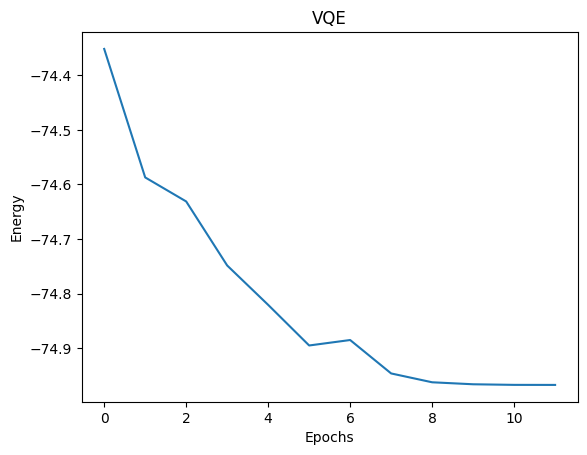

In [20]:
np.random.seed(42)
init_params = np.random.normal(0, 1, parameter_count)

result_vqe=minimize(objective_function,init_params, method='L-BFGS-B', jac=True, tol=1e-8, options={'maxiter': 10})

print('VQE-UCCSD energy= ', result_vqe.fun)

import matplotlib.pyplot as plt

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

## 2- Batch the Spin Hamiltonia terms:

<div>
<img src="./ham-batch.png" width="600">
</div>

In [21]:
import cudaq
from cudaq import spin

import timeit

cudaq.set_target("nvidia", option="mqpu")

#cudaq.mpi.initialize()

qubit_count = 22
term_count = 100000

@cudaq.kernel
def batch_ham():
    qubits=cudaq.qvector(qubit_count)
    h(qubits[0])
    for i in range(1, qubit_count):
        x.ctrl(qubits[0], qubits[i])

# We create a random Hamiltonian
hamiltonian = cudaq.SpinOperator.random(qubit_count, term_count)

# The observe calls allows us to calculate the expectation value of the Hamiltonian with respect to a specified kernel.

start_time = timeit.default_timer()
# Single node, single GPU.
result = cudaq.observe(batch_ham, hamiltonian).expectation()
end_time = timeit.default_timer()
print('Elapsed time (s) for single-GPU: ', end_time-start_time)

# If we have multiple GPUs/ QPUs available, we can parallelize the workflow with the addition of an argument in the observe call.

start_time = timeit.default_timer()
# Single node, multi-GPU.
result = cudaq.observe(batch_ham, hamiltonian, execution=cudaq.parallel.thread).expectation()
end_time = timeit.default_timer()
print('Elapsed time (s) for multi-GPU: ', end_time-start_time)


# Multi-node, multi-GPU. (if included use mpirun -np n filename.py)
#result = cudaq.observe(batch_ham, hamiltonian, execution=cudaq.parallel.mpi).expectation()

#cudaq.mpi.finalize()

Elapsed time (s) for single-GPU:  2.3234453659970313
Elapsed time (s) for multi-GPU:  4.76827342499746


### 3- Multi-GPU and scaling

The multi-GPU NVIDIA target (`mgpu` option) backend is useful for running a large single quantum circuit spread across multiple GPUs.

- A $n$ qubit quantum state has $2^n$ complex amplitudes, each of which require 8 bytes of memory to store. Hence the total memory required to store a n qubit quantum state is $8$ bytes $\times 2^n$. For $n=30$ qubits, this is roughly $8$ GB but for $n=40$, this exponentially increases to $8700$ GB.

- For instance, a 3-qubit system with 8 state vector elements can be equally distributed to 4 GPUs as described in the following figure.

<div>
<img src="./sv-parallel.png" width="400">
</div>

#### Example: GHZ

```python

# mpirun -np 4 python <fname> --target nvidia --target-option mgpu

import cudaq

cudaq.mpi.initialize()

qubit_count = 30

@cudaq.kernel
def kernel(qubit_num: int):
    # Allocate our qubits.
    qvector = cudaq.qvector(qubit_num)
    # Place the first qubit in the superposition state.
    h(qvector[0])
    # Loop through the allocated qubits and apply controlled-X,
    # or CNOT, operations between them.
    for qubit in range(qubit_num - 1):
        x.ctrl(qvector[qubit], qvector[qubit + 1])
    # Measure the qubits.
    mz(qvector)

#print("Preparing GHZ state for", qubit_count, "qubits.")
counts = cudaq.sample(kernel, qubit_count)

if cudaq.mpi.rank() == 0:
    print(counts)

cudaq.mpi.finalize()
```

In [142]:
!mpirun -np 4 python ghz.py --target nvidia --target-option mgpu

{ 000000000000000000000000000000:513 111111111111111111111111111111:487 }



## 4- Remote-mQPU:

<div>
<img src="./remote-mqpu.png" width="700">
</div>

the multi-QPU NVIDIA platform enables multi-QPU distribution whereby each QPU is simulated by a single NVIDIA GPU. To run multi-QPU workloads on different simulator backends, one can use the remote-mqpu platform, which encapsulates simulated QPUs as independent HTTP REST server instances.

By default, auto launching daemon services do not support MPI parallelism. Hence, using the nvidia-mgpu backend to simulate each virtual QPU requires manually launching each server instance. 

``` python

CUDA_VISIBLE_DEVICES=0,1 mpiexec -np 2 python3 cudaq-qpud --port <QPU 1 TCP/IP port number>
CUDA_VISIBLE_DEVICES=2,3 mpiexec -np 2 python3 cudaq-qpud --port <QPU 2 TCP/IP port number>
CUDA_VISIBLE_DEVICES=4,5 mpiexec -np 2 python3 cudaq-qpud --port <QPU 3 TCP/IP port number>
CUDA_VISIBLE_DEVICES=6,7 mpiexec -np 2 python3 cudaq-qpud --port <QPU 4 TCP/IP port number>
```

```<QPU n TCP/IP port number>```: The network ports just need to be available, so you can pick random numbers between ~1100 and ~49000.

Note: If the port is unavailable, it will report an error saying something like "failed to bind to port"

Note: When you are done with the servers, you need to manually kill them.

``` python

import cudaq
from cudaq import spin
import numpy as np

np.random.seed(1)

backend = 'nvidia-mgpu'
servers = "localhost:30001,localhost:30002"

# Set the target to execute on and query the number of QPUs in the system;
# The number of QPUs is equal to the number of (auto-)launched server instances.
cudaq.set_target("remote-mqpu",
                    backend=backend,
                    auto_launch=str(servers) if servers.isdigit() else "",
                    url="" if servers.isdigit() else servers)
qpu_count = cudaq.get_target().num_qpus()
print("Number of virtual QPUs:", qpu_count)

qubit_count = 30
sample_count = 2

ham = spin.z(0)

parameter_count = qubit_count

# Below we run a circuit for 500 different input parameters.
parameters = np.random.default_rng(13).uniform(low=0,high=1,size=(sample_count,parameter_count))

print('Parameter shape: ', parameters.shape)

@cudaq.kernel
def kernel_rx(theta:list[float]):
    qubits = cudaq.qvector(qubit_count)

    for i in range(qubit_count):
        rx(theta[i], qubits)

# Multi-GPU

# We split our parameters into 2 arrays 
xi = np.split(parameters,2)

print('We have', parameters.shape[0],
      'parameters which we would like to execute')

print('We split this into', len(xi), 'batches of', xi[0].shape[0], ',',
      xi[1].shape[0])

print('Shape after splitting', xi[0].shape)
asyncresults = []


for i in range(len(xi)):
    for j in range(xi[i].shape[0]):
        asyncresults.append(
            cudaq.observe_async(kernel_rx, ham, xi[i][j, :], qpu_id=i))


print('Energies from multi-GPUs')
for result in asyncresults:
    observe_result = result.get()
    got_expectation = observe_result.expectation()
    print(got_expectation)

```

To execute this job, use:

``` python
CUDA_VISIBLE_DEVICES=0,1 mpiexec -np 2 cudaq-qpud --port 30001 &

CUDA_VISIBLE_DEVICES=2,3 mpiexec -np 2 cudaq-qpud --port 30002 &

python3 observe-qml-remote-mqpu.py

```

Output:

``` python

Number of virtual QPUs: 2
Parameter shape:  (2, 30)
We have 2 parameters which we would like to execute
We split this into 2 batches of 1 , 1
Shape after splitting (1, 30)
Energies from multi-GPUs
-0.17012869483974752
-0.9906678983711331

```


``` python

cudaq.set_target("remote-mqpu",
                    backend=backend,
                    auto_launch=str(servers) if servers.isdigit() else "",
                    url="" if servers.isdigit() else servers)

```


If the use case is simple enough, then the CUDA-Q runtime can auto-launch the server for you. For example, if servers is '2', then auto_launch='2' and url=''. The CUDA-Q runtime will interpret that to mean that it should auto-launch 2 servers and it will auto-pick the ports, so the user doesn't need to specify the URL.

But if servers is a comma-separated list of servers (like 'localhost:30001,localhost:30002' ), then auto_launch='' and url='localhost:30001,localhost:30002' . That means the CUDA-Q runtime WON'T auto launch the servers and will use the provided url to connect to when submitting programs to the backend.